In [156]:
# Audio pre-processor

from ntpath import isdir
import librosa
import numpy as np
import pandas as pd
import subprocess
import os
import glob

config = {
    'target_sr': 22050,
    'duration': 3,
    'overlap_ratio': 0.5,
}

class AudioProcessor:

    def __init__(self, config):
        self.config = config
        self.target_sr = config['target_sr']
        self.duration = config['duration']
        self.overlap_ratio = config['overlap_ratio']

    def load_audio(self, file_path):
        """load audio / optionally convert mp3 to wav for lossless processing"""
        # wav_file = file_path.replace('.mp3', '.wav')
        # subprocess.run(['ffmpeg', '-i', file_path, wav_file], check=True)
        audio, sr = librosa.load(file_path)
        return audio, sr
    
    def chunk_audio(self, audio):
        """chunk audio into 3 seconds chunks with 50% overlap"""
        chunk_len = int(self.target_sr * self.duration)
        hop_len = int(chunk_len * (1 - self.overlap_ratio))
        chunks = []
        for start_idx in range(0, len(audio) - chunk_len + 1, hop_len):
            end_idx = start_idx + chunk_len
            chunk = audio[start_idx:end_idx]
            chunks.append(chunk)
        return chunks

    def calculate_snr(self, chunks):
        """calculate snr of each chunk"""
        snr = []
        for chunk in chunks:
            rms = np.sqrt(np.mean(chunk ** 2))
            snr.append(rms)
        return snr
    
    def extract_patient_info(self, patient_dir):
        patient_info = {
            'name': None,
            'age': None,
            'gender': None,
        }
        try:
            parts = patient_dir.strip().split('-')
            # name-age-gender-condition
            patient_info['name'] = parts[0].strip()
            age_str = parts[1].strip()
            if age_str and age_str.isdigit():
                patient_info['age'] = int(age_str)
            gender = parts[2].strip()
            clean_gender = ''.join(filter(str.isalpha, gender)).lower()
            if clean_gender in ['m', 'male']:
                patient_info['gender'] = 'Male'
            elif clean_gender in ['f', 'female']:
                patient_info['gender'] = 'Female'
            else:
                patient_info['gender'] = None

        except Exception as e:
            print(f"Error extracting patient info from {patient_dir}: {e}") 
        return patient_info


def load_dataset(data_dir):
    processor = AudioProcessor(config)
    dataset = []

    # process benign directory
    benign_dir = os.path.join(data_dir, 'Benign')
    if os.path.exists(benign_dir):
        for patient_folder in os.listdir(benign_dir):
            patient_dir = os.path.join(os.path.join(benign_dir, patient_folder))
            if os.path.isdir(patient_dir):
                for audio_file in glob.glob(os.path.join(patient_dir, '*.mp3')) + \
                                  glob.glob(os.path.join(patient_dir, '*.m4a')):
                    patient_info = processor.extract_patient_info(patient_folder)
                    audio, sr = processor.load_audio(audio_file)
                    if audio is not None:
                        chunks = processor.chunk_audio(audio)
                        for chunk in chunks:
                            dataset.append({
                                'filepath': audio_file,
                                'audio': chunk,
                                'label': 'benign',
                                'name': patient_info['name'],
                                'age': patient_info['age'],
                                'gender': patient_info['gender'],
                            })
    
    #process normal directory
    normal_dir = os.path.join(data_dir, 'Normal')
    if os.path.exists(normal_dir):
        for patient_folder in os.listdir(normal_dir):
            patient_dir = os.path.join(os.path.join(normal_dir, patient_folder))
            if os.path.isdir(patient_dir):
                for audio_file in glob.glob(os.path.join(patient_dir, '*.mp3')) + \
                                  glob.glob(os.path.join(patient_dir, '*.m4a')):
                    audio, sr = processor.load_audio(audio_file)
                    patient_info = processor.extract_patient_info(patient_folder)
                    if audio is not None:
                        chunks = processor.chunk_audio(audio)
                        for chunk in chunks:
                            dataset.append({
                                'filepath': audio_file,
                                'audio': chunk,
                                'label': 'normal',
                                'name': patient_info['name'],
                                'age': patient_info['age'],
                                'gender': patient_info['gender'],
                            })

    # process malignant directory
    malignant_dir = os.path.join(data_dir, 'Malignant')
    if os.path.exists(malignant_dir):
        for patient_folder in os.listdir(malignant_dir):
            patient_dir = os.path.join(os.path.join(malignant_dir, patient_folder))
            if os.path.isdir(patient_dir):
                for audio_file in glob.glob(os.path.join(patient_dir, '*.mp3')) + \
                                  glob.glob(os.path.join(patient_dir, '*.m4a')):
                    patient_info = processor.extract_patient_info(patient_folder)
                    audio, sr = processor.load_audio(audio_file)
                    if audio is not None:
                        chunks = processor.chunk_audio(audio)
                        for chunk in chunks:
                            dataset.append({
                                'filepath': audio_file,
                                'audio': chunk,
                                'label': 'malignant',
                                'name': patient_info['name'],
                                'age': patient_info['age'],
                                'gender': patient_info['gender'],
                            })
    
    return pd.DataFrame(dataset)

data_dir = '/Users/mudi/voice-model/data/v2/'
print("Loading dataset...")
df = load_dataset(data_dir)
print(f"Dataset loaded with {len(df)} samples")


Loading dataset...


Note: Illegal Audio-MPEG-Header 0x31323439 at offset 7520640.
Note: Trying to resync...
/var/folders/sd/zywz_szx6rd500k_lds9thtr0000gn/T/ipykernel_3066/2334311509.py:29: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path)
/Users/mudi/voice-model/venv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
Note: Illegal Audio-MPEG-Header 0x372c3830 at offset 5408640.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync li

Dataset loaded with 5416 samples


In [157]:
print("Dataset loaded with {} samples".format(len(df)))

df.head()

Dataset loaded with 5416 samples


,filepath,audio,label,name,age,gender
0,/Users/mudi/voice-model/data/v2/Benign/Ram kis...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",benign,Ram kishore,57,Male
1,/Users/mudi/voice-model/data/v2/Benign/Ram kis...,"[0.0012806341, 0.006340105, 0.008703977, 0.004...",benign,Ram kishore,57,Male
2,/Users/mudi/voice-model/data/v2/Benign/Ram kis...,"[0.001511344, 0.0015389966, -0.0039935103, -0....",benign,Ram kishore,57,Male
3,/Users/mudi/voice-model/data/v2/Benign/Ram kis...,"[0.0054030884, 0.0077270446, 0.009807814, 0.00...",benign,Ram kishore,57,Male
4,/Users/mudi/voice-model/data/v2/Benign/Ram kis...,"[0.018908605, 0.023849137, 0.026417194, 0.0299...",benign,Ram kishore,57,Male


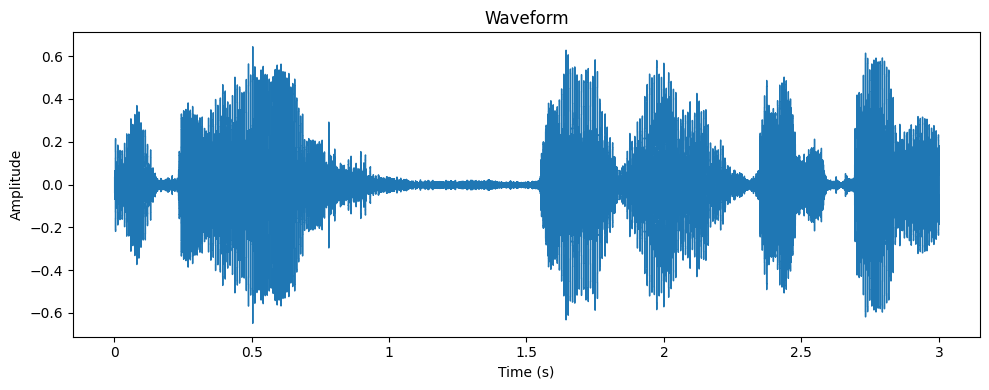

In [159]:
import matplotlib.pyplot as plt
import IPython.display as ipd
from IPython.display import display

def get_audio(sample):
    return ipd.Audio(sample['audio'], rate=config['target_sr'])

def get_waveform(sample):
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(sample['audio'], sr=config['target_sr'])
    plt.title("Waveform")
    plt.ylabel("Amplitude")
    plt.xlabel("Time (s)")
    plt.tight_layout()

# plot a sample audio
sample = df.iloc[100]
display(get_audio(sample))
get_waveform(sample)


In [165]:
df.drop(columns = ['duration', 'rms_frames', 'rms_mean'], inplace = True)
meta = []
for (i, row) in df.iterrows():
    meta.append({
        "rms_frames": librosa.feature.rms(y=row['audio'], frame_length=1024, hop_length=256)[0],
        "rms_mean": float(np.mean(librosa.feature.rms(y=row['audio'], frame_length=1024, hop_length=256)[0])),
    })

meta_df = pd.DataFrame(meta, index=df.index)
df = df.join(meta_df)


In [166]:
df

,filepath,audio,label,name,age,gender,rms_frames,rms_mean
0,/Users/mudi/voice-model/data/v2/Benign/Ram kis...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",benign,Ram kishore,57,Male,"[0.0, 0.0, 0.0, 0.0, 3.374385e-13, 6.987224e-1...",0.016977
1,/Users/mudi/voice-model/data/v2/Benign/Ram kis...,"[0.0012806341, 0.006340105, 0.008703977, 0.004...",benign,Ram kishore,57,Male,"[0.0056915535, 0.006719605, 0.0077285874, 0.00...",0.011173
2,/Users/mudi/voice-model/data/v2/Benign/Ram kis...,"[0.001511344, 0.0015389966, -0.0039935103, -0....",benign,Ram kishore,57,Male,"[0.0032150801, 0.0037993998, 0.0042574806, 0.0...",0.047347
3,/Users/mudi/voice-model/data/v2/Benign/Ram kis...,"[0.0054030884, 0.0077270446, 0.009807814, 0.00...",benign,Ram kishore,57,Male,"[0.005313819, 0.0062972493, 0.0071266973, 0.00...",0.088199
4,/Users/mudi/voice-model/data/v2/Benign/Ram kis...,"[0.018908605, 0.023849137, 0.026417194, 0.0299...",benign,Ram kishore,57,Male,"[0.0837652, 0.09856907, 0.11248823, 0.10502744...",0.123157
...,...,...,...,...,...,...,...,...
5411,/Users/mudi/voice-model/data/v2/Malignant/Dine...,"[0.028548438, -0.0034408816, 0.027202444, 0.03...",malignant,Dinesh,56,Male,"[0.03831021, 0.059669882, 0.07980819, 0.086811...",0.061746
5412,/Users/mudi/voice-model/data/v2/Malignant/Chun...,"[-1.5937969e-05, -4.8036287e-05, -4.7061196e-0...",malignant,Chunnu,58,Female,"[0.0018485372, 0.0034222389, 0.0048045395, 0.0...",0.046748
5413,/Users/mudi/voice-model/data/v2/Malignant/Chun...,"[-0.031067844, -0.016597705, 0.10609308, 0.137...",malignant,Chunnu,58,Female,"[0.114800185, 0.13819467, 0.15660624, 0.152344...",0.053491
5414,/Users/mudi/voice-model/data/v2/Malignant/Chun...,"[0.025168663, -0.04863538, -0.017703347, 0.010...",malignant,Chunnu,58,Female,"[0.025694495, 0.029357104, 0.03281845, 0.02954...",0.046795


In [167]:
df.describe()

,age,rms_mean
count,5416.000000,5416.000000
mean,46.099705,0.087510
std,12.428842,0.036608
min,15.000000,0.007538
25%,39.000000,0.057383
50%,48.000000,0.087889
75%,55.000000,0.115481
max,70.000000,0.207151


<Axes: xlabel='label'>

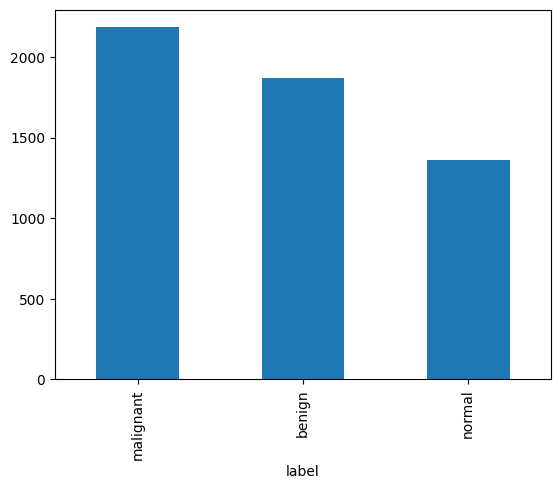

In [168]:
df['label'].value_counts().plot(kind='bar')

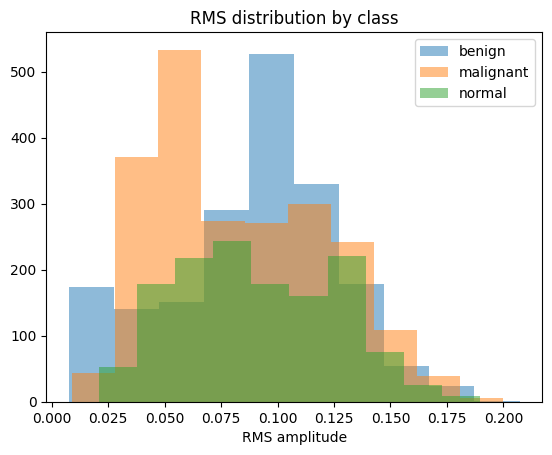

In [170]:
def rms_distribution(df):
    plt.hist(df[df.label=="benign"]["rms_mean"], alpha=0.5, label="benign")
    plt.hist(df[df.label=="malignant"]["rms_mean"], alpha=0.5, label="malignant")
    plt.hist(df[df.label=="normal"]["rms_mean"], alpha=0.5, label="normal")
    plt.xlabel("RMS amplitude")
    plt.legend()
    plt.title("RMS distribution by class")
    plt.show()
"""
RMS amplitude distributions for benign and malignant voices are broadly similar,
with benign voices slightly louder on average. The strong overlap suggests RMS alone is not a reliable classifier,
 but the small shift and absence of extreme outliers indicate reasonably consistent recording levels across groups.
"""
rms_distribution(df)

In [171]:
def snr_from_rms_frames(row, noise_frac=0.1, signal_frac=0.5):
    rms = row['rms_frames']
    if rms is None or len(rms) == 0:
        return np.nan

    rms = np.asarray(rms, dtype=float)
    rms_sorted = np.sort(rms)
    n = len(rms_sorted)

    # noise: bottom noise_frac
    n_noise = max(1, int(noise_frac * n))
    noise_rms = np.mean(rms_sorted[:n_noise])

    # signal: top signal_frac
    start_signal = int((1.0 - signal_frac) * n)
    signal_rms = np.mean(rms_sorted[start_signal:])

    return 20 * np.log10((signal_rms + 1e-12) / (noise_rms + 1e-12))

df['snr_db'] = df.apply(snr_from_rms_frames, axis=1)


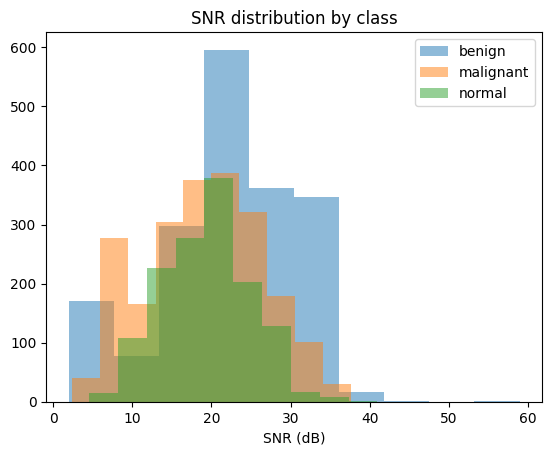

low snr frames count:  (574, 9)
updated dataset shape:  (4842, 9)


In [172]:
def snr_distribution(df):
    plt.hist(df[df.label=="benign"]["snr_db"], alpha=0.5, label="benign")
    plt.hist(df[df.label=="malignant"]["snr_db"], alpha=0.5, label="malignant")
    plt.hist(df[df.label=="normal"]["snr_db"], alpha=0.5, label="normal")
    plt.xlabel("SNR (dB)")
    plt.legend()
    plt.title("SNR distribution by class")
    plt.show()

snr_distribution(df)

sample_low_snr_frames = df[df['snr_db'] < 10]
print("low snr frames count: ", sample_low_snr_frames.shape)
# print(sample_low_snr_frames.head())
# get_waveform(.iloc[0])

# drop low snr frames
clean_df = df[df['snr_db'] > 10]
print("updated dataset shape: ", clean_df.shape)




In [176]:
# extract f0 features
# adult male fq range - 85 - 180Hz and female 165 - 255Hz
import parselmouth
from parselmouth import praat
from scipy import signal
from tqdm import tqdm

def find_sustained_segment(y, sr,
                           min_duration=0.6,
                           min_voiced_ratio=0.5,
                           max_f0_sd=60.0,
                           fmin=75, fmax=500,
                           top_db=25):
    """
    Returns a 1D numpy array: the best sustained phonation segment
    from y, or y itself as fallback.

    Heuristic:
    - Remove low-energy/silent parts (VAD)
    - For each non-silent interval:
        * compute F0 with pyin
        * require enough voiced frames
        * require low F0 standard deviation
    - pick the interval with best score (voiced_ratio * duration / (1 + f0_sd/scale))
    """

    y = np.asarray(y, dtype=float)

    # 1) Energy-based VAD: non-silent intervals
    intervals = librosa.effects.split(y, top_db=top_db)

    if intervals.size == 0:
        # nothing detected as non-silent, fallback
        return y

    best_score = -np.inf
    best_seg = None

    for start, end in intervals:
        seg = y[start:end]
        dur = (end - start) / sr
        if dur < min_duration:
            continue

        # 2) F0 contour in this interval
        try:
            f0, voiced_flag, _ = librosa.pyin(
                seg,
                fmin=fmin,
                fmax=fmax,
                sr=sr,
                frame_length=2048,
                hop_length=512,
                fill_na=np.nan,
            )
        except Exception:
            continue

        if f0 is None:
            continue

        voiced_mask = ~np.isnan(f0)
        voiced_ratio = voiced_mask.mean()

        if voiced_ratio < min_voiced_ratio:
            # too much unvoiced stuff, skip
            continue

        voiced_f0 = f0[voiced_mask]
        f0_sd = np.std(voiced_f0)

        if f0_sd > max_f0_sd:
            # F0 too wobbly, not a stable vowel
            continue

        # 3) scoring: prefer long & highly voiced & stable
        score = voiced_ratio * dur / (1.0 + f0_sd / 50.0)

        if score > best_score:
            best_score = score
            best_seg = seg

    if best_seg is None:
        # No good candidate found – fallback to central segment
        # so you still get *something* for these measures
        total = len(y) / sr
        if total <= min_duration:
            return y
        start_t = (total - min_duration) / 2
        end_t = start_t + min_duration
        start = int(start_t * sr)
        end = int(end_t * sr)
        return y[start:end]

    return best_seg


def compute_f0_features(audio, sr, f_max = 500, f_min = 75):
    f0, voiced_flag, voiced_probs = librosa.pyin(
        audio, 
        fmin = f_min, 
        fmax = f_max, 
        sr = sr,
        frame_length = 2048,
        hop_length = 512,
        fill_na = np.nan
        )

    if f0 is None or np.all(np.isnan(f0)):
        return {k: np.nan for k in [
            "f0_mean","f0_median","f0_min","f0_max","f0_sd","f0_range"
        ]}
    voiced_f0 = f0[~np.isnan(f0)]
    if voiced_f0.size == 0:
        return {k: np.nan for k in [
            "f0_mean","f0_median","f0_min","f0_max","f0_sd","f0_range"
        ]}
    return {
        "f0_mean": float(np.mean(voiced_f0)),
        "f0_median": float(np.median(voiced_f0)),
        "f0_min": float(np.min(voiced_f0)),
        "f0_max": float(np.max(voiced_f0)),
        "f0_sd": float(np.std(voiced_f0)),
        "f0_range": float(np.max(voiced_f0) - np.min(voiced_f0)),
    }


def compute_praat_measures(audio, sr):
    segment = find_sustained_segment(audio, sr)
    sound = parselmouth.Sound(segment, sampling_frequency = sr)
    point_process = praat.call(sound, 'To PointProcess (periodic, cc)', 75, 500)
    # jitter
    jitter_local = praat.call(point_process, 'Get jitter (local)', 0, 0, 0.0001, 0.02, 1.3)
    jitter_rap = praat.call(point_process, 'Get jitter (rap)', 0, 0, 0.0001, 0.02, 1.3)
    jitter_ppq5 = praat.call(point_process, 'Get jitter (ppq5)', 0, 0, 0.0001, 0.02, 1.3)
    # shimmer
    shimmer_local = praat.call([sound, point_process], 'Get shimmer (local)', 0, 0, 0.0001, 0.02, 1.3, 1.6)
    shimmer_apq3 = praat.call([sound, point_process], 'Get shimmer (apq3)', 0, 0, 0.0001, 0.02, 1.3, 1.6)
    shimmer_apq5 = praat.call([sound, point_process], 'Get shimmer (apq5)', 0, 0, 0.0001, 0.02, 1.3, 1.6)
    shimmer_apq11 = praat.call([sound, point_process], 'Get shimmer (apq11)', 0, 0, 0.0001, 0.02, 1.3, 1.6)
    # hnr
    hnr = praat.call(sound, 'To Harmonicity (cc)', 0.01, 75, 0.1, 1.0)
    hnr_mean = praat.call(hnr, 'Get mean', 0, 0)
    # cpp
    cp = praat.call(sound, "To PowerCepstrogram", 60, 0.002, 5000, 50)
    cpps = praat.call(cp, "Get CPPS", "yes", 0.02, 0.0005, 60, 330, 0.05, "parabolic", 0.001, 0.05, "Straight", "Robust")
    # voice breaks
    # n_breaks, degree_breaks, total_break_dur, analysed_dur = \
    #     point_process.get_count_and_fraction_of_voice_breaks(
    #         from_time=None,
    #         to_time=None,
    #         period_ceiling=0.02,  # same as 1 / (50 Hz) typical
    #     )
    #cpp_mean = praat.call(cpps, "Get mean", 0, 0)
    return dict(
        jitter_local = float(jitter_local),
        jitter_rap = float(jitter_rap),
        jitter_ppq5 = float(jitter_ppq5),
        shimmer_local = float(shimmer_local),
        shimmer_apq3 = float(shimmer_apq3),
        shimmer_apq5 = float(shimmer_apq5),
        shimmer_apq11 = float(shimmer_apq11),
        hnr_mean = float(hnr_mean),
        cpp_mean = float(cpps),
        # voice_break_ratio = float(degree_breaks),
    )

def spectral_features(y, sr):
    S = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))
    # basic stuff
    centroid = librosa.feature.spectral_centroid(S=S, sr=sr).mean()
    flatness = librosa.feature.spectral_flatness(S=S).mean()
    zcr      = librosa.feature.zero_crossing_rate(y).mean()
    rolloff  = librosa.feature.spectral_rolloff(S=S, sr=sr, roll_percent=0.85).mean()
    return dict(
        spectral_centroid=float(centroid),
        spectral_flatness=float(flatness),
        zcr=float(zcr),
        spectral_rolloff_85=float(rolloff),
    )

def ltas_bands(y, sr):
    freqs, Pxx = signal.welch(y, fs=sr, nperseg=4096)
    total = np.trapz(Pxx, freqs) + 1e-12
    def band_energy(f_low, f_high):
        mask = (freqs >= f_low) & (freqs < f_high)
        if not np.any(mask):
            return np.nan
        band_power = np.trapz(Pxx[mask], freqs[mask])
        return float(band_power / total)
    return dict(
        ltas_0_1k = band_energy(0, 1000),
        ltas_1_2k = band_energy(1000, 2000),
        ltas_2_4k = band_energy(2000, 4000),
        ltas_4_8k = band_energy(4000, 8000),
    )


def extract_features_from_audio(row):
    audio = row['audio']
    sr = config['target_sr']
    feats = {
        "filepath": row['filepath'],
        "name": row['name'],
        "age": row['age'],
        "gender": row['gender'],
        "audio": row['audio'],
        "label": row['label'],
        "rms_mean": row['rms_mean'],
        "snr_db": row['snr_db'],
    }
    feats.update(compute_f0_features(audio, sr))
    feats.update(compute_praat_measures(audio, sr))
    feats.update(spectral_features(audio, sr))
    feats.update(ltas_bands(audio, sr))
    return feats

clean_df.head()
rows = []
for _, row in tqdm(clean_df.iterrows(), total = len(clean_df)):
    rows.append(extract_features_from_audio(row))

feat_df = pd.DataFrame(rows)
feat_df.head()


  0%|          | 0/4842 [00:00<?, ?it/s]/var/folders/sd/zywz_szx6rd500k_lds9thtr0000gn/T/ipykernel_3066/1120872073.py:184: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total = np.trapz(Pxx, freqs) + 1e-12
/var/folders/sd/zywz_szx6rd500k_lds9thtr0000gn/T/ipykernel_3066/1120872073.py:189: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  band_power = np.trapz(Pxx[mask], freqs[mask])
100%|██████████| 4842/4842 [20:18<00:00,  3.97it/s]


,filepath,name,age,gender,audio,label,rms_mean,snr_db,f0_mean,f0_median,...,hnr_mean,cpp_mean,spectral_centroid,spectral_flatness,zcr,spectral_rolloff_85,ltas_0_1k,ltas_1_2k,ltas_2_4k,ltas_4_8k
0,/Users/mudi/voice-model/data/v2/Benign/Ram kis...,Ram kishore,57,Male,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",benign,0.016977,23.124570,NaN,NaN,...,1.136763,5.065386,2709.995149,0.073606,0.163266,5500.573918,0.610987,0.153365,0.108435,0.113196
1,/Users/mudi/voice-model/data/v2/Benign/Ram kis...,Ram kishore,57,Male,"[0.0012806341, 0.006340105, 0.008703977, 0.004...",benign,0.011173,13.513617,NaN,NaN,...,5.698047,3.797112,2691.224438,0.040996,0.169659,5376.840820,0.656715,0.143415,0.105561,0.080780
2,/Users/mudi/voice-model/data/v2/Benign/Ram kis...,Ram kishore,57,Male,"[0.001511344, 0.0015389966, -0.0039935103, -0....",benign,0.047347,28.259922,166.816793,142.401318,...,11.084772,8.033415,2046.319293,0.018781,0.108849,4130.482459,0.989377,0.005736,0.002530,0.001368
3,/Users/mudi/voice-model/data/v2/Benign/Ram kis...,Ram kishore,57,Male,"[0.0054030884, 0.0077270446, 0.009807814, 0.00...",benign,0.088199,32.148228,143.891609,133.634808,...,10.230743,8.105918,2132.589013,0.019932,0.105315,4355.090332,0.975034,0.003789,0.002906,0.016392
4,/Users/mudi/voice-model/data/v2/Benign/Ram kis...,Ram kishore,57,Male,"[0.018908605, 0.023849137, 0.026417194, 0.0299...",benign,0.123157,30.072383,125.765632,124.685684,...,15.874075,9.375935,2220.506048,0.017917,0.109811,4536.548978,0.983307,0.001824,0.002321,0.011178


In [177]:
feat_df.columns

Index(['filepath', 'name', 'age', 'gender', 'audio', 'label', 'rms_mean',
       'snr_db', 'f0_mean', 'f0_median', 'f0_min', 'f0_max', 'f0_sd',
       'f0_range', 'jitter_local', 'jitter_rap', 'jitter_ppq5',
       'shimmer_local', 'shimmer_apq3', 'shimmer_apq5', 'shimmer_apq11',
       'hnr_mean', 'cpp_mean', 'spectral_centroid', 'spectral_flatness', 'zcr',
       'spectral_rolloff_85', 'ltas_0_1k', 'ltas_1_2k', 'ltas_2_4k',
       'ltas_4_8k'],
      dtype='object')

In [178]:
temp_df = feat_df.copy()

print("Null values: ", temp_df.isna().sum())
temp_df.dropna(inplace = True)

temp_df.to_csv("features_with_name.csv", index=False)

Null values:  filepath                 0
name                     0
age                      0
gender                   0
audio                    0
label                    0
rms_mean                 0
snr_db                   0
f0_mean                206
f0_median              206
f0_min                 206
f0_max                 206
f0_sd                  206
f0_range               206
jitter_local           139
jitter_rap             164
jitter_ppq5            206
shimmer_local          176
shimmer_apq3           213
shimmer_apq5           289
shimmer_apq11          457
hnr_mean                 0
cpp_mean                 0
spectral_centroid        0
spectral_flatness        0
zcr                      0
spectral_rolloff_85      0
ltas_0_1k                0
ltas_1_2k                0
ltas_2_4k                0
ltas_4_8k                0
dtype: int64


In [126]:
features_df = feat_df.copy()

y = (features_df["label"] == "malignant").astype(int)
groups = features_df["filepath"]
X = features_df.drop(columns=["label", "audio", "filepath", "duration"])

X.isna().sum().sort_values()

X.dropna(inplace = True)


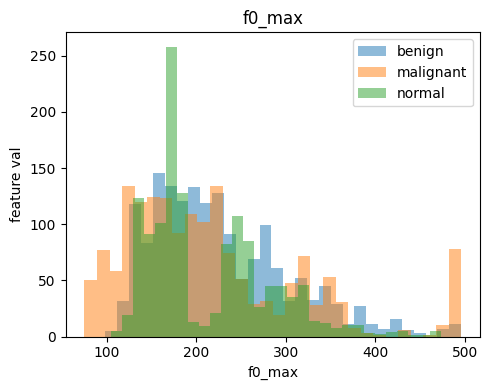

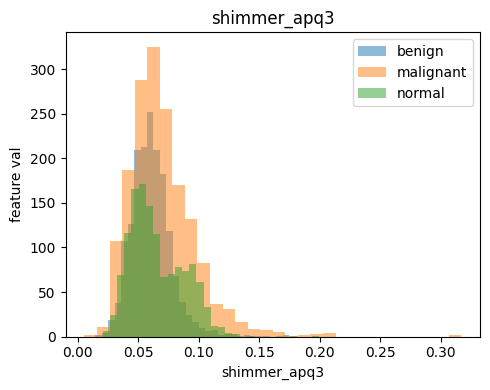

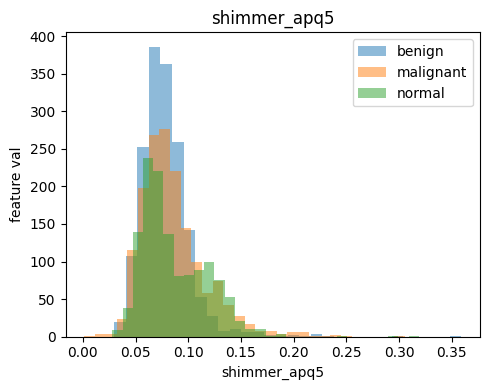

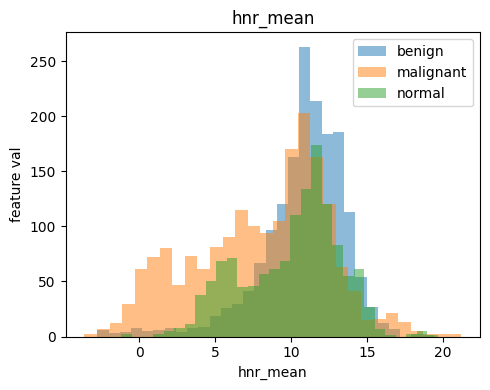

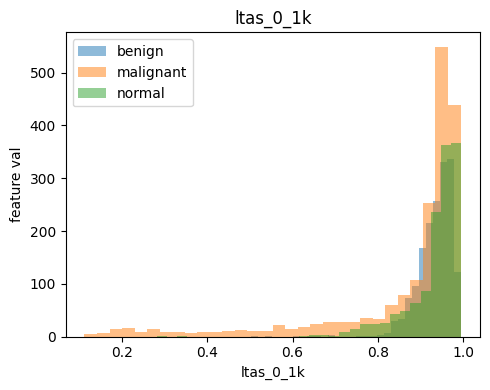

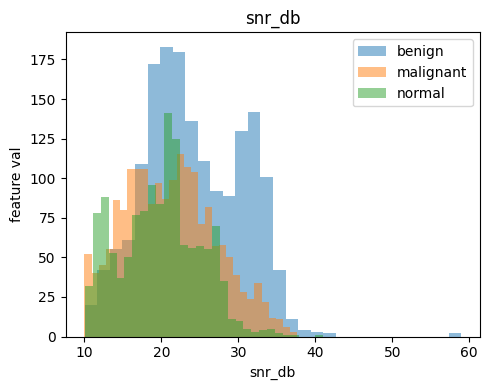

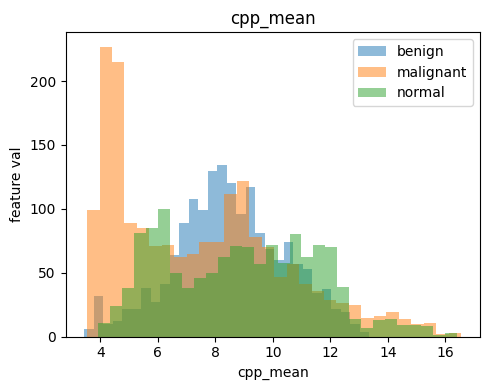

In [127]:
def plot_hist_by_label(df, feature, bins=30):
    plt.figure(figsize=(5,4))
    for lab, color in zip(["benign", "malignant", "normal"], ["tab:blue", "tab:orange", "tab:green"]):
        vals = df[df["label"] == lab][feature].dropna().values
        plt.hist(vals, bins=bins, alpha=0.5, label=lab)
    plt.title(feature)
    plt.xlabel(feature)
    plt.ylabel("feature val")
    plt.legend()
    plt.tight_layout()
    plt.show()

for feat in ["f0_max", "shimmer_apq3", "shimmer_apq5", "hnr_mean", "ltas_0_1k", "snr_db", "cpp_mean"]:
    if feat in features_df.columns:
        plot_hist_by_label(features_df, feat)

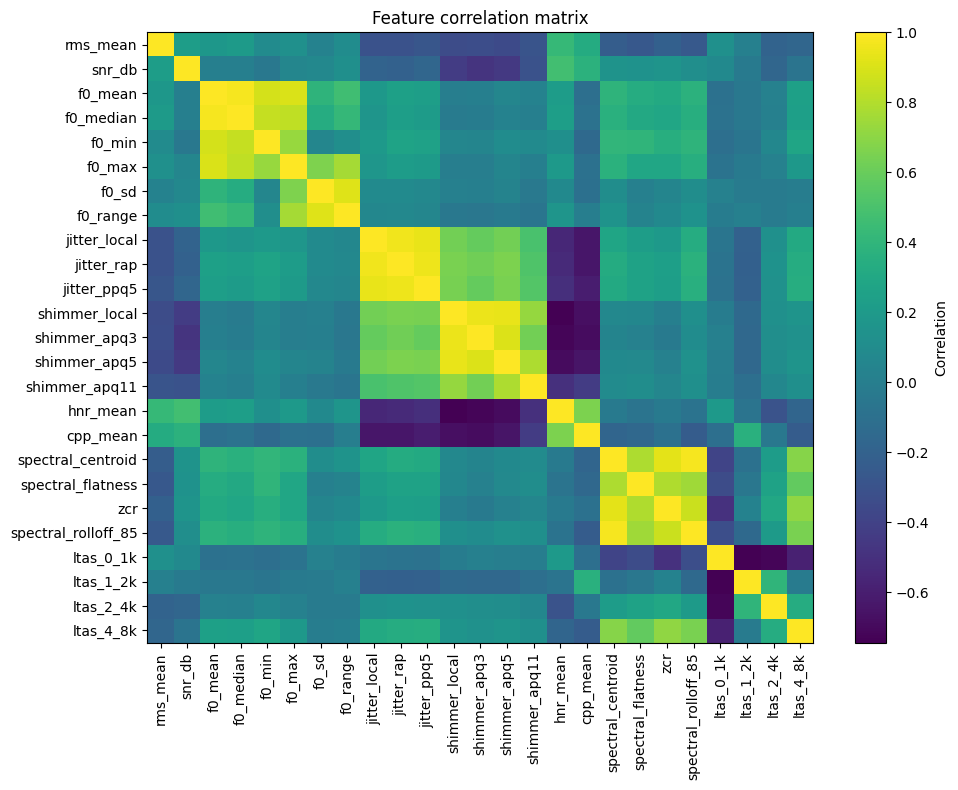

In [128]:
num_cols = [c for c in X.columns if X[c].dtype != object]
corr = X[num_cols].corr()

plt.figure(figsize=(10,8))
plt.imshow(corr, aspect="auto")
plt.colorbar(label="Correlation")
plt.xticks(range(len(num_cols)), num_cols, rotation=90)
plt.yticks(range(len(num_cols)), num_cols)
plt.title("Feature correlation matrix")
plt.tight_layout()
plt.show()

In [129]:
features_df.isna().sum()
features_df.shape
features_df.dropna(inplace = True)



In [ ]:
###
# DEPRECEATED
###

# Cell: Feature Selection Comparison
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
import numpy as np

# Prepare data
xgb_df = features_df.copy()
label_encoder = LabelEncoder()
xgb_y = label_encoder.fit_transform(xgb_df["label"])
groups = xgb_df["filepath"].values

# Define feature sets
significant_features = ['f0_max', 'shimmer_apq3', 'shimmer_apq5', 'cpp_mean', 'ltas_0_1k']
raw_significant_features = ['f0_median', 'f0_range', 'jitter_rap', 'shimmer_local', 'spectral_flatness']
selected_features = significant_features + raw_significant_features

# All features (excluding metadata)
all_features = [col for col in xgb_df.columns 
                if col not in ['label', 'audio', 'filepath', 'duration', 'rms_mean', 'snr_db']]

print("All available features:", len(all_features))
print("Selected features (significant + raw significant):", len(selected_features))
print("\nSelected features:", selected_features)

# Split data
gss = GroupShuffleSplit(test_size=0.25, n_splits=1, random_state=42)
train_idx, test_idx = next(gss.split(xgb_df, xgb_y, groups=groups))

# Test 1: Only statistically significant features (5 features)
X_sig = xgb_df[significant_features].values
X_sig_train, X_sig_test = X_sig[train_idx], X_sig[test_idx]
y_train, y_test = xgb_y[train_idx], xgb_y[test_idx]

imputer = SimpleImputer(strategy="median")
X_sig_train = imputer.fit_transform(X_sig_train)
X_sig_test = imputer.transform(X_sig_test)

xgb_sig = XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False
)
xgb_sig.fit(X_sig_train, y_train)
y_pred_sig = xgb_sig.predict(X_sig_test)

print("\n" + "="*60)
print("MODEL 1: Only 5 Statistically Significant Features")
print("="*60)
print(classification_report(y_test, y_pred_sig, target_names=label_encoder.classes_))
print(f"Accuracy: {accuracy_score(y_test, y_pred_sig):.4f}")
print(f"F1-score (macro): {f1_score(y_test, y_pred_sig, average='macro'):.4f}")

# Test 2: Significant + Raw Significant (10 features)
X_sel = xgb_df[selected_features].values
X_sel_train, X_sel_test = X_sel[train_idx], X_sel[test_idx]

imputer_sel = SimpleImputer(strategy="median")
X_sel_train = imputer_sel.fit_transform(X_sel_train)
X_sel_test = imputer_sel.transform(X_sel_test)

xgb_sel = XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False
)
xgb_sel.fit(X_sel_train, y_train)
y_pred_sel = xgb_sel.predict(X_sel_test)

print("\n" + "="*60)
print("MODEL 2: 5 Significant + 5 Raw Significant Features (10 total)")
print("="*60)
print(classification_report(y_test, y_pred_sel, target_names=label_encoder.classes_))
print(f"Accuracy: {accuracy_score(y_test, y_pred_sel):.4f}")
print(f"F1-score (macro): {f1_score(y_test, y_pred_sel, average='macro'):.4f}")

# Test 3: All features (let XGBoost select)
X_all = xgb_df[all_features].values
X_all_train, X_all_test = X_all[train_idx], X_all[test_idx]

imputer_all = SimpleImputer(strategy="median")
X_all_train = imputer_all.fit_transform(X_all_train)
X_all_test = imputer_all.transform(X_all_test)

xgb_all = XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False
)
xgb_all.fit(X_all_train, y_train)
y_pred_all = xgb_all.predict(X_all_test)

print("\n" + "="*60)
print("MODEL 3: All Features (XGBoost feature selection)")
print("="*60)
print(classification_report(y_test, y_pred_all, target_names=label_encoder.classes_))
print(f"Accuracy: {accuracy_score(y_test, y_pred_all):.4f}")
print(f"F1-score (macro): {f1_score(y_test, y_pred_all, average='macro'):.4f}")

# Feature importance comparison
print("\n" + "="*60)
print("FEATURE IMPORTANCE (Model 3 - All Features)")
print("="*60)
feature_importance = pd.DataFrame({
    'feature': all_features,
    'importance': xgb_all.feature_importances_
}).sort_values('importance', ascending=False)


All available features: 23
Selected features (significant + raw significant): 10

Selected features: ['f0_max', 'shimmer_apq3', 'shimmer_apq5', 'cpp_mean', 'ltas_0_1k', 'f0_median', 'f0_range', 'jitter_rap', 'shimmer_local', 'spectral_flatness']


/Users/mudi/voice-model/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:28:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



MODEL 1: Only 5 Statistically Significant Features
              precision    recall  f1-score   support

      benign       0.52      0.57      0.55       337
   malignant       0.43      0.33      0.38       272
      normal       0.74      0.81      0.77       340

    accuracy                           0.59       949
   macro avg       0.56      0.57      0.56       949
weighted avg       0.57      0.59      0.58       949

Accuracy: 0.5869
F1-score (macro): 0.5640


/Users/mudi/voice-model/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:28:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



MODEL 2: 5 Significant + 5 Raw Significant Features (10 total)
              precision    recall  f1-score   support

      benign       0.43      0.48      0.45       337
   malignant       0.32      0.29      0.30       272
      normal       0.76      0.72      0.74       340

    accuracy                           0.51       949
   macro avg       0.50      0.50      0.50       949
weighted avg       0.52      0.51      0.51       949

Accuracy: 0.5132
F1-score (macro): 0.4997


/Users/mudi/voice-model/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:28:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



MODEL 3: All Features (XGBoost feature selection)
              precision    recall  f1-score   support

      benign       0.55      0.58      0.57       337
   malignant       0.53      0.45      0.49       272
      normal       0.76      0.80      0.78       340

    accuracy                           0.62       949
   macro avg       0.61      0.61      0.61       949
weighted avg       0.62      0.62      0.62       949

Accuracy: 0.6238
F1-score (macro): 0.6112

FEATURE IMPORTANCE (Model 3 - All Features)


In [118]:
print(feature_importance.head(10))

              feature  importance
1           f0_median    0.091079
17          ltas_0_1k    0.075161
12           cpp_mean    0.074030
14  spectral_flatness    0.063209
0             f0_mean    0.060884
3              f0_max    0.056768
10       shimmer_apq5    0.053057
19          ltas_2_4k    0.047438
13  spectral_centroid    0.046910
11           hnr_mean    0.045826


In [131]:
features_df.to_csv("features_df.csv", index = False)

In [148]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from xgboost import XGBClassifier
import numpy as np

# 1. Prepare data
xgb_df = features_df.copy()

# Target and groups
y_raw  = xgb_df["label"].values
groups = xgb_df["filepath"].values

# Drop non-numeric / non-feature columns
X = xgb_df.drop(columns=["label", "audio", "filepath", "duration"])

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)

# 2. Group-wise train/test split (patient-wise)
gss = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y[train_idx], y[test_idx]
groups_train = groups[train_idx]

# 3. Preprocessing: impute + scale
preproc = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

X_train_proc = preproc.fit_transform(X_train)
X_test_proc  = preproc.transform(X_test)

# Class weight to improve recall
class_names = list(label_encoder.classes_)
malignant_idx = class_names.index("malignant")   # works only if label exists exactly as "malignant"

malignant_boost = 2.5  # try 1.5, 2.0, 2.5, 3.0
sample_weight = np.ones_like(y_train, dtype=float)
sample_weight[y_train == malignant_idx] = malignant_boost

# 4. XGBoost classifier (multi-class)
xgb_all = XGBClassifier(
    n_estimators=400,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="multi:softprob",
    eval_metric="mlogloss",
    n_jobs=-1,
    random_state=42,
)

xgb_all.fit(X_train_proc, y_train, sample_weight=sample_weight)

# 5. Evaluation
y_pred_all = xgb_all.predict(X_test_proc)

print("="*60)
print("MODEL: All Features (XGBoost feature selection)")
print("="*60)
print(classification_report(y_test, y_pred_all, target_names=label_encoder.classes_))
print(f"Accuracy: {accuracy_score(y_test, y_pred_all):.4f}")
print(f"F1-score (macro): {f1_score(y_test, y_pred_all, average='macro'):.4f}")

# 6. Feature importance
all_features = X.columns.tolist()
feature_importance = (
    pd.DataFrame({
        'feature': all_features,
        'importance': xgb_all.feature_importances_,
    })
    .sort_values('importance', ascending=False)
)

class_names = label_encoder.classes_
labels_idx = range(len(class_names)) 

print("\n" + "="*60)
print("FEATURE IMPORTANCE (Model - All Features)")
print("="*60)
print(feature_importance.head(15))

print("="*60)
print("MODEL: All Features (XGBoost feature selection)")
print("="*60)
cm = confusion_matrix(y_test, y_pred_all, labels=labels_idx)
print(pd.DataFrame(cm, index=class_names, columns=class_names))


MODEL: All Features (XGBoost feature selection)
              precision    recall  f1-score   support

      benign       0.62      0.76      0.68       337
   malignant       0.71      0.49      0.58       272
      normal       0.75      0.77      0.76       340

    accuracy                           0.69       949
   macro avg       0.70      0.67      0.68       949
weighted avg       0.69      0.69      0.68       949

Accuracy: 0.6870
F1-score (macro): 0.6757

FEATURE IMPORTANCE (Model - All Features)
                feature  importance
2               f0_mean    0.075062
3             f0_median    0.070402
18    spectral_flatness    0.053552
4                f0_min    0.049508
17    spectral_centroid    0.048737
20  spectral_rolloff_85    0.048610
16             cpp_mean    0.048215
22            ltas_1_2k    0.047444
21            ltas_0_1k    0.047186
24            ltas_4_8k    0.046433
0              rms_mean    0.043418
23            ltas_2_4k    0.041094
10          jitter

In [154]:
probs = xgb_all.predict_proba(X_test_proc)

class_names = label_encoder.classes_
malignant_idx = list(class_names).index("malignant")

threshold = 0.225  # start here, tune later

y_pred_thr = []

for i in range(len(probs)):
    if probs[i, malignant_idx] >= threshold:
        y_pred_thr.append(malignant_idx)
    else:
        tmp = probs[i].copy()
        tmp[malignant_idx] = -1  # exclude malignant
        y_pred_thr.append(int(np.argmax(tmp)))

y_pred_thr = np.array(y_pred_thr)

print(classification_report(y_test, y_pred_thr, target_names=class_names))
print("Accuracy:", accuracy_score(y_test, y_pred_thr))
print("Macro F1:", f1_score(y_test, y_pred_thr, average="macro"))
print("="*60)
cm = confusion_matrix(y_test, y_pred_thr, labels=labels_idx)
print(pd.DataFrame(cm, index=class_names, columns=class_names))



              precision    recall  f1-score   support

      benign       0.66      0.62      0.64       337
   malignant       0.57      0.64      0.60       272
      normal       0.78      0.74      0.76       340

    accuracy                           0.67       949
   macro avg       0.67      0.67      0.67       949
weighted avg       0.68      0.67      0.67       949

Accuracy: 0.672286617492097
Macro F1: 0.6691451864150211
           benign  malignant  normal
benign        210         91      36
malignant      60        175      37
normal         46         41     253


In [139]:
from sklearn.metrics import precision_recall_fscore_support

results = []

for thr in np.linspace(0.15, 0.50, 15):
    preds = []
    for i in range(len(probs)):
        if probs[i, malignant_idx] >= thr:
            preds.append(malignant_idx)
        else:
            tmp = probs[i].copy()
            tmp[malignant_idx] = -1
            preds.append(int(np.argmax(tmp)))
    preds = np.array(preds)

    p, r, f1, _ = precision_recall_fscore_support(
        y_test, preds, labels=[malignant_idx], average=None
    )
    macro_f1 = f1_score(y_test, preds, average="macro")
    acc = accuracy_score(y_test, preds)

    results.append((thr, p[0], r[0], f1[0], macro_f1, acc))

res_df = pd.DataFrame(
    results,
    columns=["threshold", "P_malignant", "R_malignant", "F1_malignant", "F1_macro", "accuracy"]
)

res_df.sort_values("R_malignant", ascending=False).head(10)


,threshold,P_malignant,R_malignant,F1_malignant,F1_macro,accuracy
0,0.150,0.474490,0.683824,0.560241,0.616187,0.619600
1,0.175,0.507003,0.665441,0.575517,0.635552,0.638567
2,0.200,0.534743,0.650735,0.587065,0.652557,0.655427
3,0.225,0.570033,0.643382,0.604491,0.669145,0.672287
4,0.250,0.596552,0.636029,0.615658,0.680220,0.683878
5,0.275,0.617329,0.628676,0.622951,0.683089,0.687039
6,0.300,0.636015,0.610294,0.622889,0.684594,0.689146
7,0.325,0.658635,0.602941,0.629559,0.689607,0.694415
8,0.350,0.666667,0.573529,0.616601,0.685055,0.691254
9,0.375,0.666667,0.544118,0.599190,0.678190,0.685985


In [143]:
# export

from pathlib import Path
import joblib
import json
from sklearn.metrics import confusion_matrix


ART = Path("artifacts")
ART.mkdir(exist_ok=True)
print("Artifacts dir:", ART.resolve())


joblib.dump(xgb_all, ART / "xgb_all.joblib")
print("Saved:", (ART / "xgb_all.joblib").resolve())

feature_names = list(X_train.columns)   # or X.columns used in fit()
(ART / "feature_schema.json").write_text(
    json.dumps({"feature_names": feature_names}, indent=2)
)
print("Saved feature schema:", len(feature_names))


joblib.dump(label_encoder, ART / "label_encoder.joblib")
print("Saved:", (ART / "label_encoder.joblib").resolve())

y_pred = xgb_all.predict(X_test)
report_dict = classification_report(y_test, y_pred, output_dict=True)
(ART / "classification_report.json").write_text(json.dumps(report_dict, indent=2))

labels = list(xgb_all.classes_) if hasattr(xgb_all, "classes_") else sorted(list(set(y_test)))
cm = confusion_matrix(y_test, y_pred, labels=labels)

labels_serializable = [
    int(label) if isinstance(label, (np.integer, np.int64)) else str(label) 
    for label in labels
]

(ART / "confusion_matrix.json").write_text(
    json.dumps({
        "labels": labels_serializable,
        "matrix": cm.astype(int).tolist()
    }, indent=2)
)



Artifacts dir: /Users/mudi/voice-model/artifacts
Saved: /Users/mudi/voice-model/artifacts/xgb_all.joblib
Saved feature schema: 25
Saved: /Users/mudi/voice-model/artifacts/label_encoder.joblib


/Users/mudi/voice-model/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mudi/voice-model/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mudi/voice-model/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

182

In [150]:
m = joblib.load(ART / "xgb_all.joblib")
schema = json.loads((ART / "feature_schema.json").read_text())["feature_names"]

# take one row from X_test and reorder columns EXACTLY
row = X_test.iloc[[0]][schema]
proba = m.predict_proba(row)[0]
pred = m.predict(row)[0]
print("pred:", pred, "proba:", proba)
print(y_test[0])







pred: 0 proba: [0.68784153 0.1531049  0.15905355]
0


In [155]:
features_df.columns

Index(['filepath', 'audio', 'label', 'duration', 'rms_mean', 'snr_db',
       'f0_mean', 'f0_median', 'f0_min', 'f0_max', 'f0_sd', 'f0_range',
       'jitter_local', 'jitter_rap', 'jitter_ppq5', 'shimmer_local',
       'shimmer_apq3', 'shimmer_apq5', 'shimmer_apq11', 'hnr_mean', 'cpp_mean',
       'spectral_centroid', 'spectral_flatness', 'zcr', 'spectral_rolloff_85',
       'ltas_0_1k', 'ltas_1_2k', 'ltas_2_4k', 'ltas_4_8k'],
      dtype='object')